In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

2023-10-04 08:16:09.536709: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-04 08:16:09.707101: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-04 08:16:10.649792: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/miniconda3/envs/tf/lib/python3.9/site-packages/cv2/../../lib64::/root/miniconda3/

In [2]:
# Getting numpy data
train_x = np.load(os.path.join(os.path.abspath('.'), 'npy', 'train_img.npy'))
test_x = np.load(os.path.join(os.path.abspath('.'), 'npy', 'test_img.npy'))
train_y = np.load(os.path.join(os.path.abspath('.'), 'npy', 'train_lab.npy'))
test_y = np.load(os.path.join(os.path.abspath('.'), 'npy', 'test_lab.npy'))

# split for validation set
train_x, valid_x, train_y, valid_y= train_test_split(train_x, train_y, test_size=0.2, random_state=4, stratify= train_y)

print('Data shape')
print(f'Train img: {train_x.shape} | Train lab: {train_y.shape}')
print(f'valid img: {valid_x.shape} | valid lab: {valid_y.shape}')
print(f'Test img: {test_x.shape} | Test lab: {test_y.shape}')


Data shape
Train img: (360, 512, 512, 1) | Train lab: (360, 2)
valid img: (90, 512, 512, 1) | valid lab: (90, 2)
Test img: (50, 512, 512, 1) | Test lab: (50, 2)


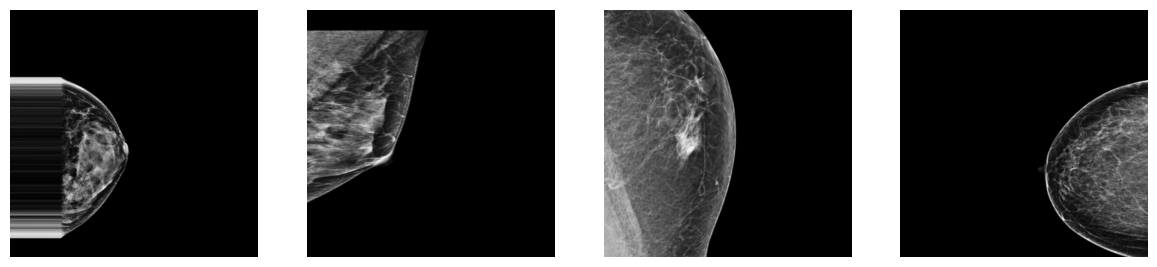

In [3]:
# Using ImageDataGenerator
## Checking output data
train_gen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip = True,
    rotation_range=0.25,
    zoom_range=[0.5, 1.5]
)
train_generator = train_gen.flow(train_x, train_y, shuffle=True, batch_size=4)
augs = train_generator.__getitem__(7)

plt.figure(figsize=(30, 30))
for i, img in enumerate(augs[0]):
    plt.subplot(4, 8, i+1)
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')

In [5]:
def Simple_CNNmodel(input_img, base = 32, scale = 2, n_layers = 6):

    x = input_img

    for n in range(n_layers):
        x = Conv2D(((scale)**n)*base, 3, activation=None, padding='same', kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = Activation(activation='relu')(x)
        x = Conv2D(((scale)**n)*base, 3, activation=None, padding='same', kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = Activation(activation='relu')(x)
        if n != n_layers:
            x = MaxPooling2D(pool_size=(2, 2))(x)
        else:
            pass
    
    out = GlobalAveragePooling2D(name="avg_pool")(x)
    out = Dense(128, activation="relu")(out)
    out = BatchNormalization()(out)
    
    out = Dense(64, activation="relu")(out)
    out = BatchNormalization()(out)
    out = Dropout(0.3)(out)
    
    out = Dense(n_class, activation="softmax")(out)
    model = Model(inputs=input_img, outputs=out)
    
    return model

In [6]:
# Training classification model using Simple CNN model with data augmentation

path_save = os.path.join(os.path.abspath('.'), 'Result', 'model_simple_augmentation')
os.makedirs(path_save, exist_ok=True)

## parameter setting
n_class = 2         
imageSize = 512     
lr = 0.0001
epochs = 50
batch = 10
loss_function = "categorical_crossentropy"

## model build
input_img = Input(shape=(imageSize,imageSize,1))

model = Simple_CNNmodel(input_img, n_class)
model.summary()         # Check model structure

## Data generator for augmentation
train_gen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip = True,
    rotation_range=0.25,
    zoom_range=[0.5, 1.5]
)
valid_gen = ImageDataGenerator()        


## Callback
checkpointer = ModelCheckpoint(filepath=os.path.join(path_save,f'best_model.h5'), 
                                verbose=1, 
                                save_weights_only=True, 
                                save_best_only=True, 
                                monitor='val_loss', 
                                save_freq='epoch')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0, min_delta=0.001, verbose=1)
callbacks_list = [reduce_lr, checkpointer]

## model compile
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(
        optimizer=optimizer, loss=loss_function, metrics=["accuracy"]
    )

## training model
model.fit(train_gen.flow(train_x, train_y, shuffle=True, batch_size=batch), 
            steps_per_epoch=len(train_x) // batch, 
            epochs=epochs,
            validation_data=valid_gen.flow(valid_x, valid_y, batch_size=batch, shuffle=False),
            callbacks=callbacks_list
                        )

## saving last model weight
model.save_weights(os.path.join(path_save,f'last_model.h5'))

2023-10-04 08:27:35.845838: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-04 08:27:36.759441: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7924 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:ca:00.0, compute capability: 8.0


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 2)       20        
                                                                 
 batch_normalization (BatchN  (None, 512, 512, 2)      8         
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 512, 512, 2)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 512, 2)       38        
                                                                 
 batch_normalization_1 (Batc  (None, 512, 512, 2)      8         
 hNormalization)                                             

2023-10-04 08:27:43.980142: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-10-04 08:27:46.431537: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-04 08:27:46.439046: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1d3813c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-04 08:27:46.439095: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100 80GB PCIe MIG 1g.10gb, Compute Capability 8.0
2023-10-04 08:27:46.454210: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-04 08:27:46.648086: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifeti

36/36 [==============================] - ETA: 0s - loss: 0.8745 - accuracy: 0.6028
Epoch 1: val_loss improved from inf to 0.69326, saving model to /home/user/workdir/my_data/Result/model_simple_augmentation/best_model.h5
36/36 [==============================] - 25s 233ms/step - loss: 0.8745 - accuracy: 0.6028 - val_loss: 0.6933 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/50
36/36 [==============================] - ETA: 0s - loss: 0.6958 - accuracy: 0.6583
Epoch 2: val_loss improved from 0.69326 to 0.69151, saving model to /home/user/workdir/my_data/Result/model_simple_augmentation/best_model.h5
36/36 [==============================] - 8s 221ms/step - loss: 0.6958 - accuracy: 0.6583 - val_loss: 0.6915 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/50
36/36 [==============================] - ETA: 0s - loss: 0.6683 - accuracy: 0.6472
Epoch 3: val_loss did not improve from 0.69151
36/36 [==============================] - 8s 219ms/step - loss: 0.6683 - accuracy: 0.6472 - val_loss: 0.69

KeyboardInterrupt: 

In [ ]:
# Evaluation using test data
_loss, _acc = model.evaluate(test_x, test_y, batch_size=10, verbose=1)
print('Last model accuracy')
print(f'loss: {_loss:0.3f} | accuracy: {_acc:0.3f}')

In [ ]:
## Using best model
model.load_weights(os.path.join(path_save,f'best_model.h5'))
_loss, _acc = model.evaluate(test_x, test_y, batch_size=10, verbose=1)
print('Best model accuracy')
print(f'loss: {_loss:0.3f} | accuracy: {_acc:0.3f}')

In [ ]:
# Checking fail data
test_result = model.predict(test_x, batch_size=10)

for a in range(len(test_result)):
    if test_result[a].argmax()!=test_y[a].argmax():
        plt.title(f'GT: {test_y[a].argmax()} | Result: {test_result[a].argmax()}')
        plt.imshow(test_x[a], cmap='gray')
        plt.show()

In [ ]:
def drawing_ROCcurve(test_y, test_result, path_save):
    from sklearn.metrics import roc_curve, auc
    n_classes = test_y.shape[-1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_y[:, i], test_result[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(test_y.ravel(), test_result.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    
    # First aggregate all false positive rates
    lw = 2
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10,10))
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average (auc = {0:0.2f})".format(roc_auc["micro"]),
        color="maroon",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average (auc = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    
    for i, color in zip(range(n_classes), ['blue', 'yellow']):
        plt.plot(
            fpr[i],
            tpr[i],
            lw=lw,
            label="ROC curve (auc = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel("False Positive Rate", fontsize=20)
    plt.ylabel("True Positive Rate", fontsize=20)
    plt.title("Receiver operating characteristic curves", fontsize=20)
    plt.legend(loc="lower right", fontsize=14)
    plt.savefig(f'{path_save}/ROC_curve.png')


In [ ]:
drawing_ROCcurve(test_y, model.predict(test_x), path_save)